In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import json
import pandas as pd
import traceback

sys.path.append(".") # add results folder as a python path 
from viz import *
from analyze import *

In [2]:
# Global variables and statistics
dataset = 'data20'
dataset_name = 'VGG on CIFAR10'
num_trials =100

lookup = load_lookup_data(dataset, '../lookup')
stats = get_difficulty_stats(lookup)
#print(lookup.keys())
n_samples = 20000
total_secs =  sum(lookup.exec_time)
total_hours = total_secs / 3600
mean_mins = total_secs / n_samples / 60
print(" total:  {:.2f}H, mean: {:.2f}M".format(total_hours, mean_mins))
for s in stats:
    print(s)
s = stats[3]
print("Selected target threshold: {}".format(s))
print("Global optimum: {:.4f}".format(np.max(lookup['best_acc'].values)))


 total:  1804.35H, mean: 5.41M
{'difficulty': 1.0, 'error': 0.28560000699999999, 'accuracy': 0.71439999300000001}
{'difficulty': 0.5, 'error': 0.25379997499999996, 'accuracy': 0.74620002500000004}
{'difficulty': 0.1, 'error': 0.22210001900000009, 'accuracy': 0.77789998099999991}
{'difficulty': 0.05, 'error': 0.21609997700000005, 'accuracy': 0.78390002299999995}
{'difficulty': 0.01, 'error': 0.20279997599999999, 'accuracy': 0.79720002400000001}
Selected target threshold: {'difficulty': 0.05, 'error': 0.21609997700000005, 'accuracy': 0.78390002299999995}
Global optimum: 0.8052


In [3]:
# Read sequential optimization results
results = {}
opt_secs = 86400
postfix = ".HPO_emulator({})".format(num_trials)
s_path = "./{}/T{}S/".format(dataset, opt_secs)
basic_bo = ['GP-EI', 'GP-PI', 'GP-UCB', 
              'RF-EI', 'RF-PI', 'RF-UCB' ]
rand = ['Random']
ada = ['GP-Hedge']

results['Random'] = load_json(s_path + 'RANDOM-RANDOM' + postfix + '.json')

for opt in basic_bo:
    results[opt] = load_json(s_path + opt + postfix + '.json')

#results['R-Div (hybrid)'] = load_json(s_path + 'DIV-RANDOM.hybrid' + postfix + '.json')
results['GP-Hedge'] = load_json(s_path + 'DIV-BO-HEDGE.hedge3' + postfix + '.json')

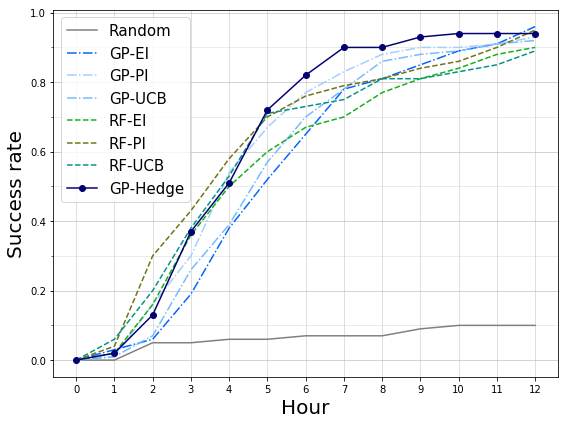

In [4]:
draw_success_rate_fig(results, s['accuracy'], 13, step_size=1,
                                              x_unit='Hour',  indi=rand+basic_bo,  ada=ada, 
                      width=8, height=6, save_name='fig-cifar10-vgg-s1', target_folder='./figs/',
                     )

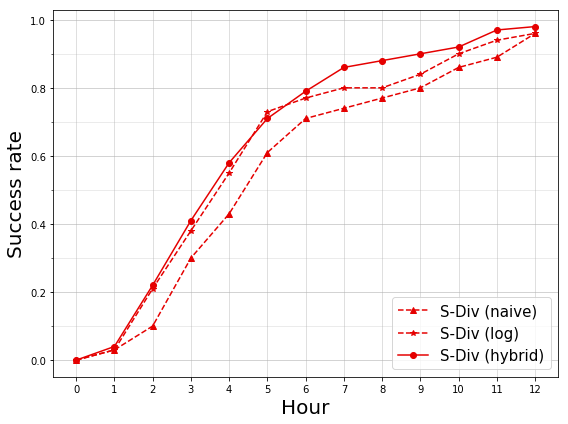

In [5]:
sdivs =['S-Div (naive)', 'S-Div (log)', 'S-Div (hybrid)',] #'GP-Hedge'] 
results['S-Div (naive)'] = load_json(s_path + 'DIV-SEQ.pure' + postfix + '.json')
results['S-Div (log)'] = load_json(s_path + 'DIV-SEQ.log' + postfix + '.json')
results['S-Div (hybrid)'] = load_json(s_path + 'DIV-SEQ.hybrid' + postfix + '.json')
#results['R-Div (hybrid)'] = load_json(s_path + 'DIV-RANDOM.hybrid' + postfix + '.json')

def restyle(name):
    marker = ''
    color = 'xkcd:red'
    line_style = '--'
    if 'naive' in name:
        marker = '^'
    elif 'log' in name:
        marker = '*' 
    elif 'hybrid' in name:
        marker = 'o'
        line_style = '-'  
    return marker, color, line_style

draw_success_rate_fig(results, s['accuracy'], 13,  legend={'loc': 4},
                                              x_unit='Hour', step_size=1, style_format=restyle,
                                               div=sdivs, 
                                                 width=8, height=6, save_name='fig-cifar10-vgg-s6', target_folder='./figs/',
                      num_runs=num_trials )

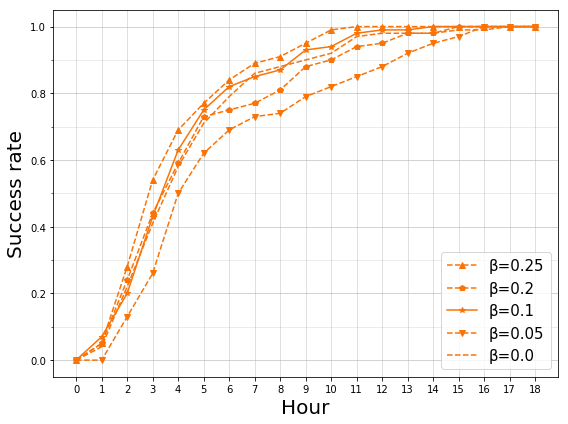

In [6]:
g_path = "./data20/G0.784/"
threshold_etrs = {}
threshold_etrs['β=0.25'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizTetra4_HL(100)' + '.json')
threshold_etrs['β=0.2'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizPenta5_HL(100)' + '.json')
threshold_etrs['β=0.1'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizDeca10_HL(100)' + '.json')
threshold_etrs['β=0.05'] = load_json(g_path + 'DIV-SEQ.HPO_emulator.ETR-VizIcosa20_HL(100)' + '.json')
threshold_etrs['β=0.0']= results['S-Div (hybrid)']


def restyle(name):
    marker = ''
    color = 'xkcd:orange'
    line_style = '--'
    if 'β=0.1' in name:
        marker = '*'
        line_style = '-'
    elif 'β=0.25' in name:
        marker = '^' 
    elif 'β=0.2' in name:
        marker = 'p'
    elif 'β=0.05' in name:
        marker = 'v'       
    return marker, color, line_style

draw_success_rate_fig(threshold_etrs, s['accuracy'], 19, 
                                              x_unit='Hour', step_size=1, 
                                               div=threshold_etrs.keys(), legend={'loc': 4}, style_format=restyle,
                                                width=8, height=6,  save_name='fig-cifar10-vgg-s7', target_folder='./figs/',
                      num_runs=num_trials )

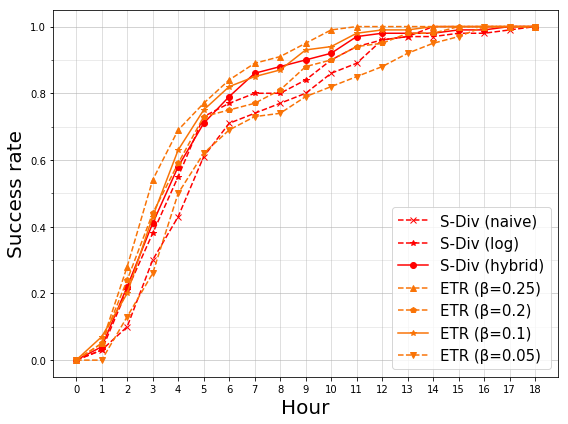

In [7]:
def restyle(name):
    marker = ''
    line_style = '--'
    color = 'red'    
    if 'ETR' in name:
        color ='xkcd:orange'
                
    if 'β=0.1' in name:
        marker = '*'  
        line_style = '-'
    elif 'β=0.25' in name:
        marker = '^' 
    elif 'β=0.2' in name:
        marker = 'p'
    elif 'β=0.05' in name:
        marker = 'v'    
    
    if '(naive)' in name:
        marker = 'x'
    elif '(log)' in name:
        marker = '*'
    elif '(hybrid)' in name:
        marker = 'o' 
        line_style = '-'
    return marker, color, line_style

thresholds = []
for key in threshold_etrs.keys():
    if key != 'β=0.0':
        results['ETR ({})'.format(key)] = threshold_etrs[key]
        thresholds.append('ETR ({})'.format(key))

draw_success_rate_fig(results, s['accuracy'], 19, 
                                              x_unit='Hour', step_size=1, 
                                               div=['S-Div (naive)', 'S-Div (log)', 'S-Div (hybrid)'] +thresholds, legend={'loc': 4}, style_format=restyle,
                                                width=8, height=6,  save_name='fig-cifar10-vgg-s8', target_folder='./figs/',
                      num_runs=num_trials )

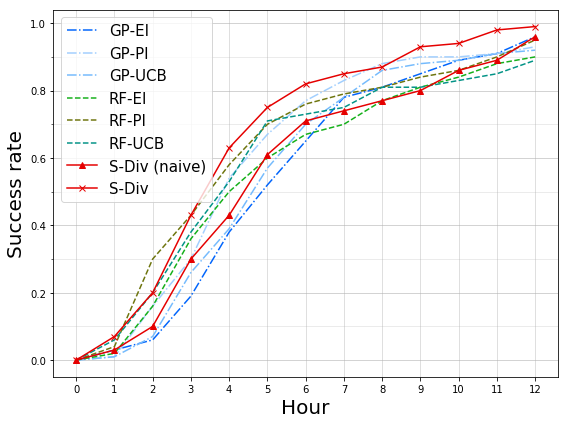

In [8]:
results['S-Div'] = threshold_etrs['β=0.1']
draw_success_rate_fig(results, s['accuracy'], 13, 
                                              x_unit='Hour', step_size=1,
                                               indi=basic_bo,  div=['S-Div (naive)',  'S-Div'], legend={'loc': 2},
                                                 width=8, height=6, save_name='fig-cifar10-vgg-s2', target_folder='./figs/',
                      num_runs=num_trials )

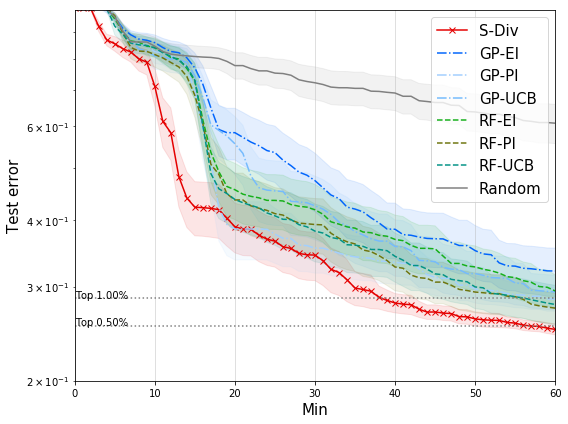

In [9]:
# FIXME:replace 24h run version
results['S-Div'] = load_json(g_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-DecaTercet(100)' + '.json')
selected =['S-Div' ] + basic_bo + rand
draw_best_error_curve(results, selected, 100,  x_unit="Min", 
                      ylim=(.2, .99), xlim=(0, 60), summary=True, x_steps=10, legend={"loc": 1}, guidelines=[stats[0], stats[1]], 
                      width=8, height=6, save_name='fig-cifar10-vgg-s3', target_folder='./figs/',
                      
                      #title="Sequential HPO of {}".format(dataset_name)
                     )

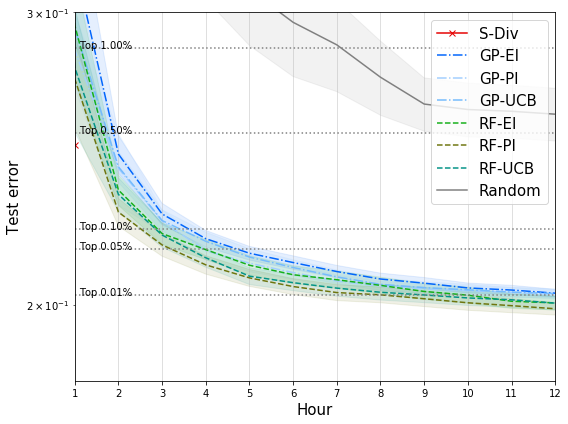

In [10]:
draw_best_error_curve(results, selected, 100, 
                      ylim=(.18, .3), xlim=(1, 12), summary=True, guidelines=stats, x_steps=1, legend={"loc": 1},
                      width=8, height=6, save_name='fig-cifar10-vgg-s4', target_folder='./figs/',
                      
                      #title="Sequential HPO of {}".format(dataset_name)
                     )

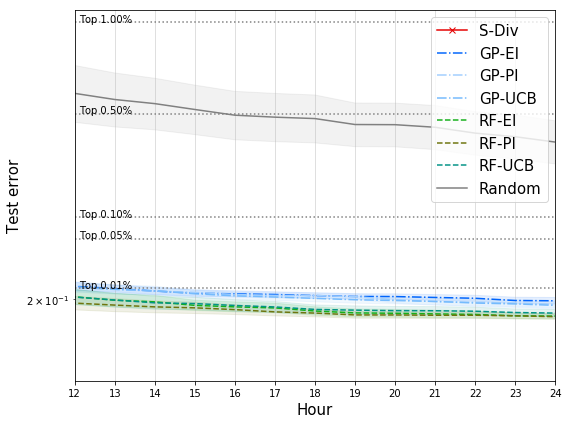

In [11]:
draw_best_error_curve(results, selected, 100, 
                      ylim=(.18, .29), xlim=(12, 24), summary=True, guidelines=stats, x_steps=1, legend={"loc": 1},
                      width=8, height=6, save_name='fig-cifar10-vgg-s5', target_folder='./figs/',
                      
                      #title="Sequential HPO of {}".format(dataset_name)
                     )

# ETR performance comparision
etr_divs = [ 'S-Div (median)', 'S-Div (interval)', 'S-Div (knock)', 'S-Div (penta)', 'S-Div (hybrid)' ] # 'BOHB (surrogate)', 
baselines = ['S-Div (baseline)', 'Random']
etr_results = {}
etr_results.update(results)
num_runs = 100
etr_results['S-Div (baseline)'] = load_json(s_path + 'DIV-SEQ.hybrid.HPO_emulator(100).json')
#etr_results['BOHB (surrogate)'] = load_json(s_path + 'BOHB.surrogate(100).json')
etr_results['S-Div (median)'] = load_json(s_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-VizMedian(100).json')
etr_results['S-Div (interval)'] = load_json(s_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-Interval(100).json')
etr_results['S-Div (knock)'] = load_json(s_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-Knock(100).json')

etr_results['S-Div (penta)'] = load_json(s_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-VizPentaOpt(100).json')
etr_results['S-Div (hybrid)'] = load_json(s_path + 'DIV-SEQ.hybrid.HPO_emulator.ETR-IntervalPentaOpt(100).json')
draw_success_rate_fig(etr_results, target_goal =s['accuracy'], x_max=24 +1, x_unit='Hour', 
                            div=baselines + etr_divs, width=14, height=8 )

print("Target goal: {}%".format(stats[1]['difficulty']))
draw_success_rate_fig(etr_results, target_goal =stats[1]['accuracy'], x_max=4*60 +1, x_unit='Min', step_size=10,
                            div=baselines + etr_divs, width=14, height=8 )

selected = baselines + etr_divs
draw_best_error_curve(etr_results, selected, num_runs, 
                      ylim=(.18, .9), xlim=(0, 1*60), summary=True, guidelines=stats, x_steps=10, x_unit='Min', 
                      title="Sequential HPO of {}".format(dataset_name))

draw_best_error_curve(etr_results, selected, num_runs, 
                      ylim=(.19, .25), xlim=(12, 24), summary=True, guidelines=stats, x_steps=1, x_unit='Hour', width=10, height=8, 
                      title="Sequential HPO of {}".format(dataset_name))

In [12]:
# Read parallel optimization results ( 6 processors)
results_6 = {}
size = 6
max_x = 2 * 6 + 1
opt_secs = 14400
postfix = "({})".format(num_trials)
p_path = "./{}/T{}S/".format(dataset, opt_secs)
results_6['Synch. GP-EI-MCMC(10)'] = load_json(p_path + 'SYNC-BATCH.M6.None.None.6GP-EI' + postfix + '.json')
results_6['GP-EI-MCMC(10)'] = load_json(p_path + 'ASYNC-BATCH.M6.None.None.6GP-EI' + postfix + '.json')
results_6['GP-EI-MCMC(1)'] = load_json(p_path + 'ASYNC-BATCH.M6.None.None.6GP-EI-no_mcmc' + postfix + '.json')
results_6['RF-EI'] = load_json(p_path + 'ASYNC-BATCH.M6.None.None.6RF-EI' + postfix + '.json')

results_6['RF-PI'] = load_json(p_path + 'ASYNC-BATCH.M6.FO-None.ETR-None.6RF-PI' + postfix + '.json')
results_6['RF-UCB'] = load_json(p_path + 'ASYNC-BATCH.M6.FO-None.ETR-None.6RF-UCB' + postfix + '.json')
#results_6['GP-PI'] = load_json(p_path + 'ASYNC-BATCH.M6.FO-None.ETR-None.6GP-PI' + postfix + '.json')
#results_6['GP-UCB'] = load_json(p_path + 'ASYNC-BATCH.M6.FO-None.ETR-None.6GP-UCB' + postfix + '.json')

path = "./data20/G0.784/"
results_6['P-Div (in-progress)'] = load_json(path + 'ASYNC-BATCH.M6.FO-premature.ETR-DecaTercet.hybrid-deca(100)' + '.json')
results_6['P-Div (naive)'] = load_json(path + 'ASYNC-BATCH.M6.FO-None.ETR-DecaTercet.hybrid-deca-no_failover(100).json')
results_6['P-Div (random)'] = load_json(path + 'ASYNC-BATCH.M6.FO-random.ETR-DecaTercet.hybrid-deca-no_failover(100).json')
results_6['P-Div (next candidate)'] = load_json(path+ 'ASYNC-BATCH.M6.FO-next_candidate.ETR-DecaTercet.hybrid-deca-next_cand(100).json')

results_6['P-Div'] = results_6['P-Div (in-progress)']

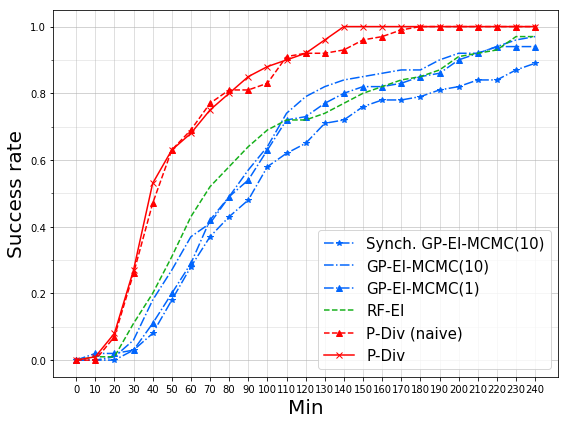

In [13]:
def restyle(name):
    marker = ''
    color ='black'
    line_style = '--'
    if 'GP-EI' in name:
        line_style = '-.'
        color = 'xkcd:bright blue'
    elif 'RF-EI' in name:
        color = 'xkcd:green'
    elif '-Div' in name:
        color = 'red'        
    if 'P-Div' == name:
        marker = 'x'
        line_style = '-'
    elif 'P-Div (naive)' == name:
        marker = '^'
    elif 'P-Div (in-progress)' == name:
        marker = 'x'
        line_style = '-'
    elif 'P-Div (random)' == name:
        marker = 'v' 
    elif 'P-Div (next candidate)' == name:
        marker = 'o'                
    elif 'MCMC(1)' in name:
        marker = '^' 
    elif 'Synch.' in name:
        marker = '*'
    return marker, color, line_style

parallels = ['Synch. GP-EI-MCMC(10)', 'GP-EI-MCMC(10)', 'GP-EI-MCMC(1)', 'RF-EI', 'P-Div (naive)', 'P-Div', ]
p_g = []
for p in parallels:
    p_g.append({"opt": p})
    
draw_success_rate_fig(results_6, s['accuracy'], 4*60 + 1, x_unit="Min",
                                              step_size=10, style_format=restyle, 
                                               parallel=p_g, 
                      width=8, height=6,  save_name='fig-cifar10-vgg-p1', target_folder='./figs/',
                      num_runs=num_trials )

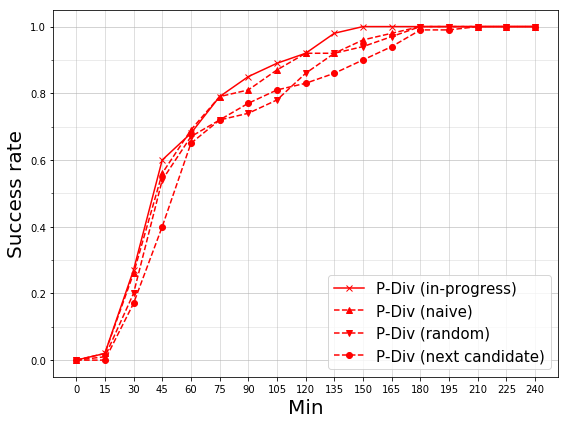

In [14]:
parallels = ['P-Div (in-progress)', 'P-Div (naive)', 'P-Div (random)', 'P-Div (next candidate)']
p_g = []
for p in parallels:
    p_g.append({"opt": p})
draw_success_rate_fig(results_6, s['accuracy'], 4*60 + 1, x_unit="Min",
                                              step_size=15, style_format=restyle, 
                                               parallel=p_g, 
                                              width=8, height=6,  save_name='fig-cifar10-vgg-p2', target_folder='./figs/',
                                              num_runs=num_trials )

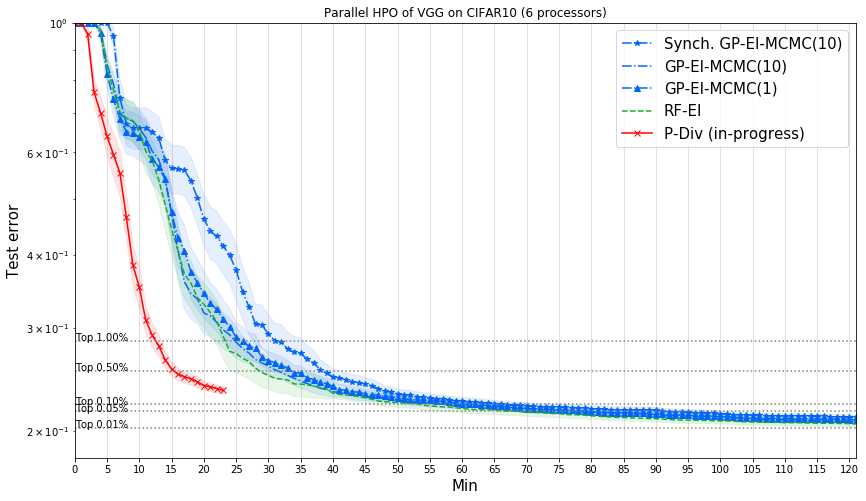

<module 'matplotlib.pyplot' from '/home/webofthink/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [15]:
selected = ['Synch. GP-EI-MCMC(10)', 'GP-EI-MCMC(10)', 'GP-EI-MCMC(1)', 'RF-EI', 'P-Div (in-progress)']

n_p = 6
num_trials = 100
flat_results_6 = {'Synch. GP-EI-MCMC(10)': results_6['Synch. GP-EI-MCMC(10)']}

for opt_name in [ 'GP-EI-MCMC(10)', 'GP-EI-MCMC(1)', 'RF-EI', 'P-Div (in-progress)']:
    sr_r = flatten_results(n_p, results_6, opt_name, num_trials)
    flat_results_6[opt_name] = sr_r

draw_best_error_curve(flat_results_6, selected, num_trials, x_unit='Min',
                      ylim=(.18, 1.0), xlim=(0, 60*2+1), summary=True, guidelines=stats, x_steps=5, style_format=restyle, 
                      title="Parallel HPO of {} (6 processors)".format(dataset_name))

In [16]:
# For sequential HPO performance table generation
summary = []
checking_hours = [6,] # 1, 2, 6, 12
s_comp_list = ['GP-EI', 'GP-PI', 'GP-UCB', 'RF-EI', 'RF-PI', 'RF-UCB', 'S-Div']
fail_summary = calc_catastrophic_failures(results, s['accuracy'], num_trials, 25)
for key in s_comp_list:
    r = {'optimizer':  key }
    #print("{} failure rates: {}".format(key,len( fail_summary[key])))
    for h in checking_hours:
        #print('after {} hours: {:.0f}%'.format(h, fail_summary[key][h] * 100))
        r['{:2d}h'.format(h)] = (1.0 - fail_summary[key][h]) * 100
    summary.append(r)
    
table = pd.DataFrame(summary)
table

,6h,optimizer
0,65.0,GP-EI
1,77.0,GP-PI
2,70.0,GP-UCB
3,67.0,RF-EI
4,76.0,RF-PI
5,73.0,RF-UCB
6,80.0,S-Div


In [17]:
# For parallel HPO performance table generation
summary = []
checking_hours = [1, ] # 2, 3, 4
p_comp_list = ['GP-EI-MCMC(10)', 'RF-EI', 'P-Div'] # 'GP-PI', 'GP-UCB', 'RF-PI', 'RF-UCB',
fail_summary = calc_catastrophic_failures(results_6, s['accuracy'], num_trials, 5)
for key in p_comp_list:
    r = {'optimizer':  key }
    #print("{} failure rates: {}".format(key,len( fail_summary[key])))
    for h in checking_hours:
        #print('after {} hours: {:.0f}%'.format(h, fail_summary[key][h] * 100))
        r['{:2d}h'.format(h)] = (1.0 - fail_summary[key][h]) * 100
    summary.append(r)
    
table1 = pd.DataFrame(summary)
table1

,1h,optimizer
0,37.0,GP-EI-MCMC(10)
1,43.0,RF-EI
2,68.0,P-Div


In [18]:
# Time to success performance table generation
summary2 = []
all_results = {}
all_results.update(results)
times = calc_time_to_achieve(all_results, s['accuracy'], num_trials)
for k in s_comp_list:
        r = times[k]
        ri = {'1_optimizer': k}
        ri['2_mean'] = r['mean']
        ri['3_sd'] = r['sd']
        summary2.append(ri)
    #print("{}: mean {:.2f}, stdev: {:.2f}".format(k, r['mean'], r['sd']))
table2 = pd.DataFrame(summary2)
table2

,1_optimizer,2_mean,3_sd
0,GP-EI,5.512982,3.051045
1,GP-PI,4.811331,3.296953
2,GP-UCB,5.362735,3.330933
3,RF-EI,5.618653,4.316076
4,RF-PI,4.661118,3.766022
5,RF-UCB,5.176507,4.190997
6,S-Div,3.903527,2.810818


In [19]:
# Time to success performance table generation
summary2 = []
all_results = {}
all_results.update(results_6)
times = calc_time_to_achieve(all_results, s['accuracy'], num_trials)
for k in p_comp_list:
        r = times[k]
        ri = {'1_optimizer': k}
        ri['2_mean'] = r['mean']
        ri['3_sd'] = r['sd']
        summary2.append(ri)
    #print("{}: mean {:.2f}, stdev: {:.2f}".format(k, r['mean'], r['sd']))
table2 = pd.DataFrame(summary2)
table2

,1_optimizer,2_mean,3_sd
0,GP-EI-MCMC(10),1.532248,0.957097
1,RF-EI,1.522699,1.054091
2,P-Div,0.874041,0.552273
